In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize']=(20,5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pyarrow.parquet as pq

In [2]:
table = pq.read_table('D:/Data_Files/DLMS Load Profile/data.parquet')

# Convert it to a Pandas DataFrame (optional)
dframe = table.to_pandas()
dframe.head(1)
dframe['Kwh']=dframe['Kwh']/1000
dframe['time']=dframe['Clock']

In [3]:
df1=dframe.groupby('sensor')

In [4]:
lst=[]
for id,datafame in df1:
    df=datafame
    
    #""" type conversion """
    df['Clock']=pd.to_datetime(df['Clock'])
    df.set_index(['Clock'],inplace=True,drop= True)
    #""" Done"""
    
    #'''validation'''
    df = df[df.index >= '2022-11-18 00:00:00']
    df = df[df.index <= '2023-10-31 23:00:00']
    # print(len(df))
    filtered_df = df[((df['R_Voltage'] == 0) | (df['Y_Voltage'] == 0) | (df['B_Voltage'] == 0)) & 
                     ((df['R_Current'] == 0) | (df['Y_Current'] == 0) | (df['B_Current'] == 0))]
    filtered_df['Kwh'] = 0
    df.loc[filtered_df.index, :] = filtered_df
    #"""" Validation Done """

    #""" Resample """
    df=df[['Kwh']].resample(rule='1H').sum()
    #""" done """

    # seasonal=seasonal_decompose(df['Kwh'],model='additive',period=24)
    # seasonal.plot().suptitle('\n additive',fontsize=12)
    # df=pd.concat([seasonal.observed,seasonal.seasonal,seasonal.trend,seasonal.resid],axis=1)
    # df.columns=["Kwh","seasonal",'trend','resid']
    # df['resid_s']=df['resid'].rolling(window=24).mean()
    # # df.dropna(inplace=True)
    # df['data']=df['Kwh']-(df['seasonal'])#+df['resid_s'])
    # # df['id']=id
    # # df['Kwh_s']=df1['Kwh']-df1['Kwh'].shift(1)
    # # df['kwh_stationary']=df1['Kwh']-df1['Kwh_s']
    # # # filtered_df=df[df['Kwh']<200]
    # # # filtered_df['Kwh'] = 200
    # # # df.loc[filtered_df.index, :] = filtered_df
    # # df['Kwh_r']=df['Kwh'].rolling(window=24).mean()
    # df.dropna(inplace=True)
    mean=df['Kwh'].mean()
# Stationary check
    result=adfuller(df['Kwh'],autolag='AIC')
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])
    
    # print('p-value:', result[1])
    if result[1]<0.05:
        print(id,'data  is stationary with score', result[1])
        #df=df.reset_index()
    
        lst.append(df)
    

5f718c439c7a78.65267835 data  is stationary with score 0.027265403987223442
62a9920f75c931.62399458 data  is stationary with score 0.008994500713489373


In [28]:
df1=lst[1]
df1

,Kwh
Clock,
2022-12-03 00:00:00,86.1
2022-12-03 01:00:00,151.2
2022-12-03 02:00:00,134.0
2022-12-03 03:00:00,144.2
2022-12-03 04:00:00,152.4
...,...
2023-10-31 19:00:00,296.0
2023-10-31 20:00:00,297.0
2023-10-31 21:00:00,309.9


<Axes: xlabel='Clock'>

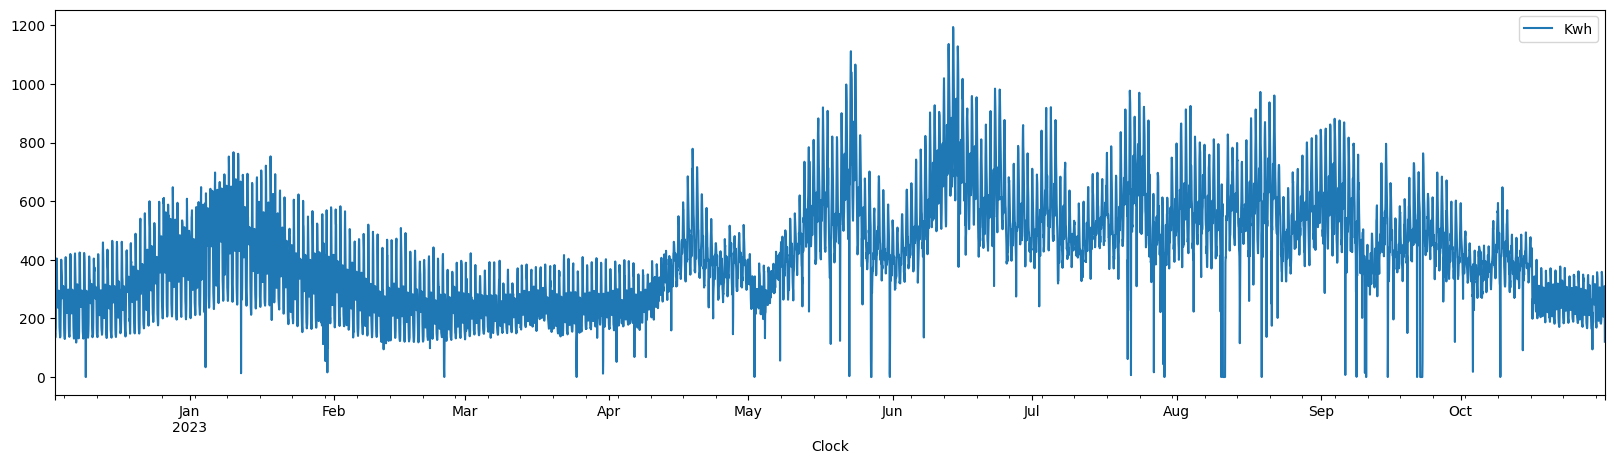

In [6]:
df1.plot()

In [7]:
train=df.iloc[:7872]
test=df.iloc[7872:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [9]:
df

,Kwh
Clock,
2022-12-03 00:00:00,86.1
2022-12-03 01:00:00,151.2
2022-12-03 02:00:00,134.0
2022-12-03 03:00:00,144.2
2022-12-03 04:00:00,152.4
...,...
2023-10-31 19:00:00,296.0
2023-10-31 20:00:00,297.0
2023-10-31 21:00:00,309.9


In [10]:

scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [11]:
scaled_train

array([[0.07211055],
       [0.12663317],
       [0.11222781],
       ...,
       [0.2220268 ],
       [0.20569514],
       [0.18927973]])

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.07211055 0.12663317 0.11222781 0.12077052 0.12763819 0.1400335
 0.20008375 0.26700168 0.27001675 0.29455611 0.33869347 0.30510888
 0.23802345 0.22026801 0.2220268  0.20670017 0.19798995 0.20485762
 0.22855946 0.23073702 0.24673367 0.22118928 0.21984925 0.17487437]
Predict this y: 
 [[0.14229481]]


In [16]:
X.shape

(1, 24, 1)

In [17]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
    
     

In [19]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50

7860/7860 [==============================] - 49s 6ms/step - loss: 0.0044
Epoch 2/50
7860/7860 [==============================] - 40s 5ms/step - loss: 0.0025
Epoch 3/50
7860/7860 [==============================] - 47s 6ms/step - loss: 0.0023
Epoch 4/50
7860/7860 [==============================] - 45s 6ms/step - loss: 0.0023
Epoch 5/50
7860/7860 [==============================] - 45s 6ms/step - loss: 0.0022
Epoch 6/50
7860/7860 [==============================] - 44s 6ms/step - loss: 0.0022
Epoch 7/50
7860/7860 [==============================] - 44s 6ms/step - loss: 0.0022
Epoch 8/50
7860/7860 [==============================] - 42s 5ms/step - loss: 0.0022
Epoch 9/50
7860/7860 [==============================] - 309s 39ms/step - loss: 0.0022
Epoch 10/50
7860/7860 [==============================] - 88s 11ms/step - loss: 0.0022
Epoch 11/50
7860/7860 [==============================] - 3922s 499ms/step - loss: 0.0021
Epoch 12/50
7860/7860 [==============================] - 91296s 12

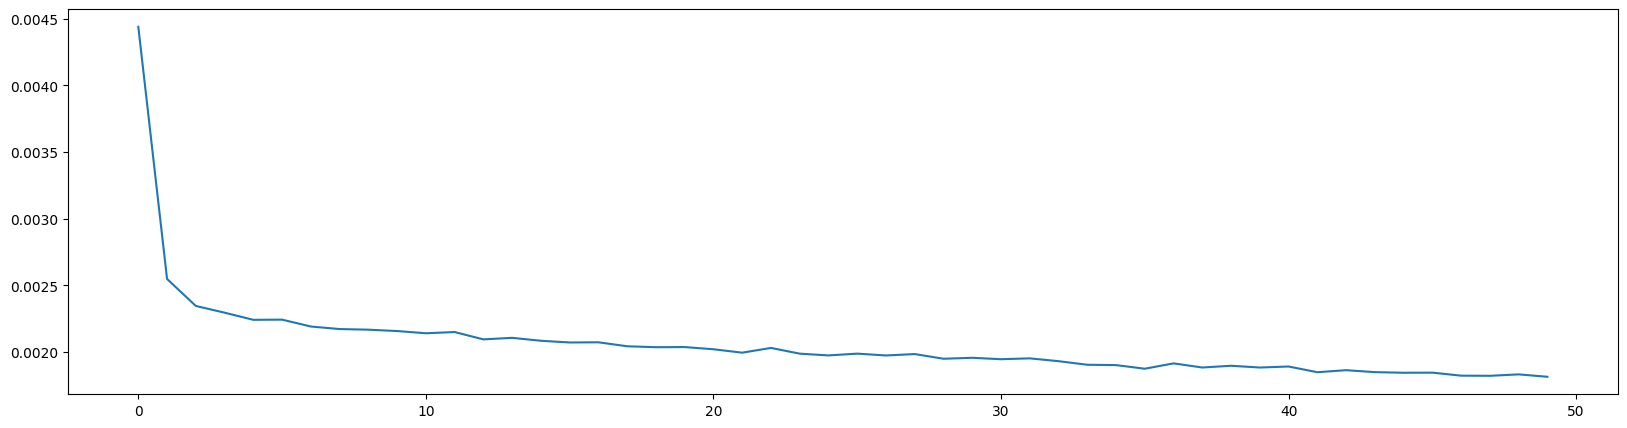

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
     

In [23]:
last_train_batch = scaled_train[-12:]

In [24]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [25]:

model.predict(last_train_batch)

1/1 [==============================] - 0s 212ms/step


array([[0.17238778]], dtype=float32)

In [26]:
scaled_test[0]
     

array([0.16457286])